In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [0]:
path_raw_data = "/path/to/data/"
!ls $path_raw_data

'ETF prices.csv'	       'MutualFund prices - L-P.csv'
 ETFs.csv		       'MutualFund prices - Q-Z.csv'
'MutualFund prices - A-E.csv'  'MutualFund prices.csv'
'MutualFund prices - F-K.csv'   MutualFunds.csv


In [0]:
# # etf data
# mf_df = pd.read_csv(path_raw_data + "ETFs.csv")

# mutual fund data
mf_df = pd.read_csv(path_raw_data + "MutualFunds.csv")

# # etf prices data
# mf_prices_df = pd.read_csv(path_raw_data + "ETF prices.csv")

# mutual fund prices data
mf_prices_ae_df = pd.read_csv(path_raw_data + "MutualFund prices - A-E.csv")
mf_prices_fk_df = pd.read_csv(path_raw_data + "MutualFund prices - F-K.csv")
mf_prices_lp_df = pd.read_csv(path_raw_data + "MutualFund prices - L-P.csv")
mf_prices_qz_df = pd.read_csv(path_raw_data + "MutualFund prices - Q-Z.csv")
mf_prices_df = pd.concat([mf_prices_ae_df, mf_prices_fk_df, mf_prices_lp_df, mf_prices_qz_df], ignore_index=True)
# mf_prices_df.to_csv("/path/to/data/MutualFund prices.csv")
# !ls $path_raw_data


# ***** Mutual Funds *****

In [0]:
print(len(mf_df))
mf_df.head(3)

23783


,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,initial_investment,subsequent_investment,fund_category,fund_family,exchange_code,exchange_name,exchange_timezone,management_name,management_bio,management_start_date,total_net_assets,year_to_date_return,day50_moving_average,day200_moving_average,week52_high_low_change,week52_high_low_change_perc,week52_high,week52_high_change,week52_high_change_perc,week52_low,week52_low_change,week52_low_change_perc,investment_strategy,fund_yield,morningstar_overall_rating,morningstar_risk_rating,inception_date,last_dividend,last_cap_gain,annual_holdings_turnover,investment_type,size_type,fund_annual_report_net_expense_ratio,category_annual_report_net_expense_ratio,...,fund_stdev_5years,fund_sharpe_ratio_5years,fund_treynor_ratio_5years,fund_alpha_10years,fund_beta_10years,fund_mean_annual_return_10years,fund_r_squared_10years,fund_stdev_10years,fund_sharpe_ratio_10years,fund_treynor_ratio_10years,fund_return_category_rank_ytd,fund_return_category_rank_1month,fund_return_category_rank_3months,fund_return_category_rank_1year,fund_return_category_rank_3years,fund_return_category_rank_5years,load_adj_return_1year,load_adj_return_3years,load_adj_return_5years,load_adj_return_10years,sustainability_score,sustainability_rank,esg_peer_group,esg_peer_count,esg_score,peer_esg_min,peer_esg_avg,peer_esg_max,environment_score,peer_environment_min,peer_environment_avg,peer_environment_max,social_score,peer_social_min,peer_social_avg,peer_social_max,governance_score,peer_governance_min,peer_governance_avg,peer_governance_max
0,AAAAX,MutualFund,US,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,USD,1000.0,50.0,World Allocation,DWS,NAS,Nasdaq,America/New_York,John Vojticek,Co-Head of Liquid Real Assets / Chief Investme...,2015-01-15,2.979347e+09,0.21026,12.788,12.369,2.44,0.18683,13.06,-0.51,-0.03905,10.62,1.93,0.18173,The investment seeks total return in excess of...,0.0186,3.0,3.0,2007-07-30,0.14660,NaN,0.74,Value,Large,0.0122,0.0102,...,11.31,0.66,6.44,-2.79,0.96,0.42,77.56,9.35,0.48,4.25,9.0,75.0,4.0,15.0,19.0,47.0,0.2456,0.0835,0.0707,0.0409,22.46,31.0,US Fund World Allocation,377.0,22.46,19.55,23.59,28.93,8.42,1.93,5.05,10.58,7.43,5.98,9.07,11.30,5.43,4.26,7.14,8.11
1,AAAEX,MutualFund,US,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,USD,1000000.0,NaN,Health,Virtus,NAS,Nasdaq,America/New_York,Christopher Chin,NaN,2020-08-27,1.953489e+08,0.19077,40.513,38.650,8.53,0.20256,42.11,-2.77,-0.06578,33.58,5.76,0.17153,The investment seeks long-term capital appreci...,NaN,3.0,2.0,2020-07-13,0.24262,NaN,0.91,Blend,Large,0.0109,0.0103,...,14.41,0.93,17.65,6.14,0.75,1.18,55.79,14.16,0.96,17.78,9.0,48.0,13.0,45.0,24.0,62.0,0.2795,0.1795,0.1448,0.1401,27.05,51.0,US Fund Health,168.0,27.05,21.07,27.98,36.79,1.42,0.34,1.43,3.27,12.96,9.52,12.87,15.08,8.40,4.96,7.68,10.30
2,AAAFX,MutualFund,US,NaN,American Century One Choice Blend+ 2015 Portfo...,USD,2500.0,50.0,Target-Date 2015,American Century Investments,NAS,Nasdaq,America/New_York,Scott A. Wilson,"Mr. Wilson, Vice President and Portfolio Manag...",2021-03-10,2.594600e+04,NaN,10.544,10.392,0.76,0.07096,10.71,-0.29,-0.02708,9.95,0.47,0.04724,The investment seeks the highest total return ...,NaN,NaN,NaN,2021-03-10,NaN,NaN,NaN,Blend,Large,0.0058,0.0041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
print(f"count of unique funds in the data = {mf_df['fund_symbol'].nunique()}")

count of unique funds in the data = 23783


## 1. Data type

In [0]:
data_types = mf_df.dtypes # data types of every column
type_counts = data_types.value_counts() # count
print("Data type counts:")
print(type_counts)

Data type counts:
float64    277
object      21
dtype: int64


In [0]:
object_cols = mf_df.select_dtypes(include=['object']).columns # object columns
print(object_cols)

Index(['fund_symbol', 'quote_type', 'region', 'fund_short_name',
       'fund_long_name', 'currency', 'fund_category', 'fund_family',
       'exchange_code', 'exchange_name', 'exchange_timezone',
       'management_name', 'management_bio', 'management_start_date',
       'investment_strategy', 'inception_date', 'investment_type', 'size_type',
       'top10_holdings', 'returns_as_of_date', 'esg_peer_group'],
      dtype='object')


In [0]:
mf_df['inception_date'] = pd.to_datetime(mf_df['inception_date']) # convert 'inception_date' column to datetime
mf_df['returns_as_of_date'] = pd.to_datetime(mf_df['returns_as_of_date']) # convert 'returns_as_of_date' column to datetime
mf_df['management_start_date'] = pd.to_datetime(mf_df['management_start_date']) # convert 'management_start_date' column to datetime

# rechecking data types now
data_types = mf_df.dtypes 
type_counts = data_types.value_counts() 
print("Data type counts:")
print(type_counts)

Data type counts:
float64           277
object             18
datetime64[ns]      3
dtype: int64


## 2. Missing values

In [0]:
missing_values = mf_df.isnull().sum() # missing values in each column
missing_cols = missing_values[missing_values > 0].sort_values() # boolean mask to filter columns with missing values
print(f"{len(missing_cols)} / {mf_df.shape[1]} columns have atleast 1 missing value")
max_missing_cols = missing_values[missing_values == missing_values.max()].index.tolist()
print(f"{len(max_missing_cols)} column(s) namely *** {max_missing_cols} *** are missing maximum values = {missing_values[max_missing_cols[0]]}")
print(f"5 columns with minimum missing values and their count")
print(missing_cols.head(5)) # 5 columns with minimum missing values and their count
print(f"5 columns with maximum missing values and their count")
print(missing_cols.tail(5)) # 5 columns with maximum missing values and their count

286 / 298 columns have atleast 1 missing value
1 column(s) namely *** ['last_cap_gain'] *** are missing maximum values = 23776
5 columns with minimum missing values and their count
day200_moving_average     1
day50_moving_average      1
fund_long_name            5
returns_as_of_date       27
total_net_assets         34
dtype: int64
5 columns with maximum missing values and their count
fund_max_front_end_sales_load    20090
fund_return_2021_q2              20166
fund_max_deferred_sales_load     20780
fund_return_2021_q3              23721
last_cap_gain                    23776
dtype: int64


Now we analyse missing values in the columns of interest

In [0]:
# columns of interest

categorical_cols = ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family']
performance_cols = ['total_net_assets', 'fund_price_earning_ratio', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_mean_annual_return_10years', 'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']


categorical_missing = mf_df[categorical_cols].isna().sum()
performance_missing = mf_df[performance_cols].isna().sum()

print('Missing values in categorical columns:')
print(categorical_missing)
print('\nMissing values in performance columns:')
print(performance_missing)

Missing values in categorical columns:
exchange_name         0
investment_type    1109
size_type          1109
fund_category       663
fund_family           0
dtype: int64

Missing values in performance columns:
total_net_assets                     34
fund_price_earning_ratio           6811
fund_mean_annual_return_5years     2896
fund_sharpe_ratio_5years           2910
fund_treynor_ratio_5years          2892
fund_mean_annual_return_10years    7079
fund_sharpe_ratio_10years          7089
fund_treynor_ratio_10years         7073
dtype: int64


In [0]:
# mf_df = mf_df.dropna(subset=categorical_cols + performance_cols)
# print(len(mf_df)) # gives 11488

If I remove all rows with null values in any of the columns of interest, then I am left with a significantly small dataset with 11488 rows --> close to 50% data loss.

Data amputation (filling proxies) is tricky because the fund performances are characteristics of so many factors. Later, if we find correlation in 5 year and 10 year performances, we can proxy one value for another while modeling. This will lead to lesser data loss.

So I instead remove only those rows that have null values together in ALL columns of interest.

Then I also drop rows with null values in categorical columns --> i.e. ['investment_type', 'size_type', 'fund_category']

In [0]:
mf_df = mf_df.dropna(subset=categorical_cols + performance_cols, how='all') # remove only those rows that have null values together in ALL columns of interest.

categorical_cols_to_dropna = ['investment_type', 'size_type', 'fund_category'] # categorical columns to drop null values from
mf_df = mf_df.dropna(subset=categorical_cols_to_dropna)

print(len(mf_df))

22025


## 3. Visualising categorical distributions

In [0]:
categorical_cols = ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family'] # categorical columns handpicked from object columns

print(f"Column : Types (unique values)")
for i, col in enumerate(categorical_cols):
    num_unique = len(mf_df[col].unique()) 
    print(f"{col} : {num_unique}")

Column : Types (unique values)
exchange_name : 1
investment_type : 3
size_type : 3
fund_category : 118
fund_family : 310


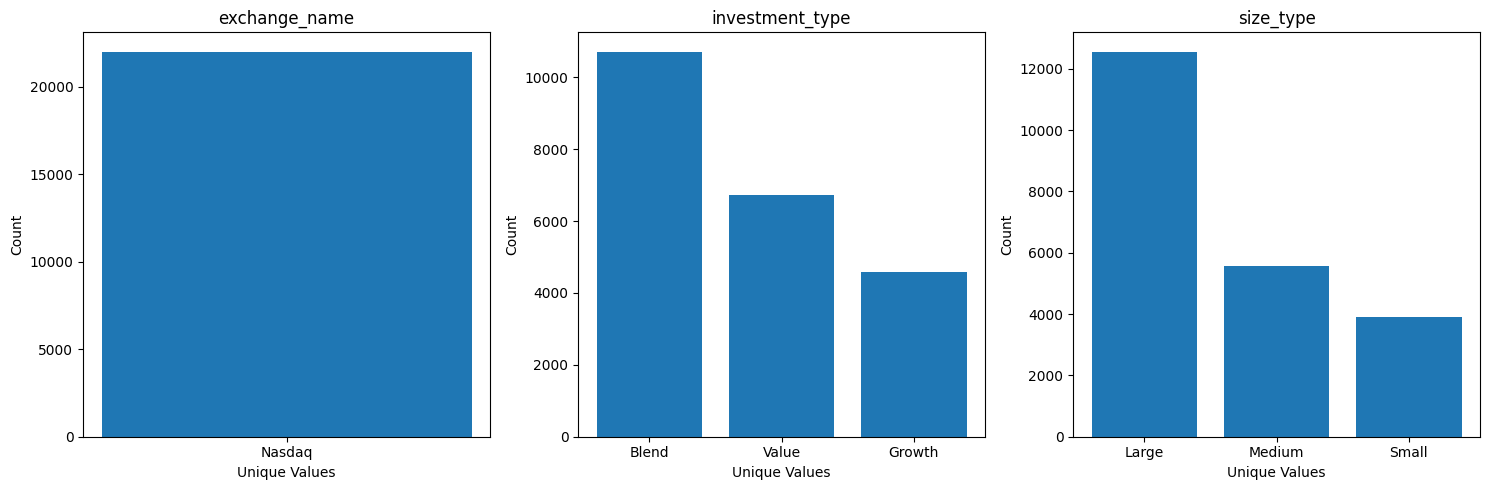

In [0]:
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']  # categorical columns with few unique values
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for i, col in enumerate(categorical_cols_1):
    value_counts = mf_df[col].value_counts().sort_values(ascending=False) # number of occurrences of each unique value
    axs[i].bar(value_counts.index, value_counts.values) # bar plots
    axs[i].set_title(col)
    axs[i].set_xlabel('Unique Values')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

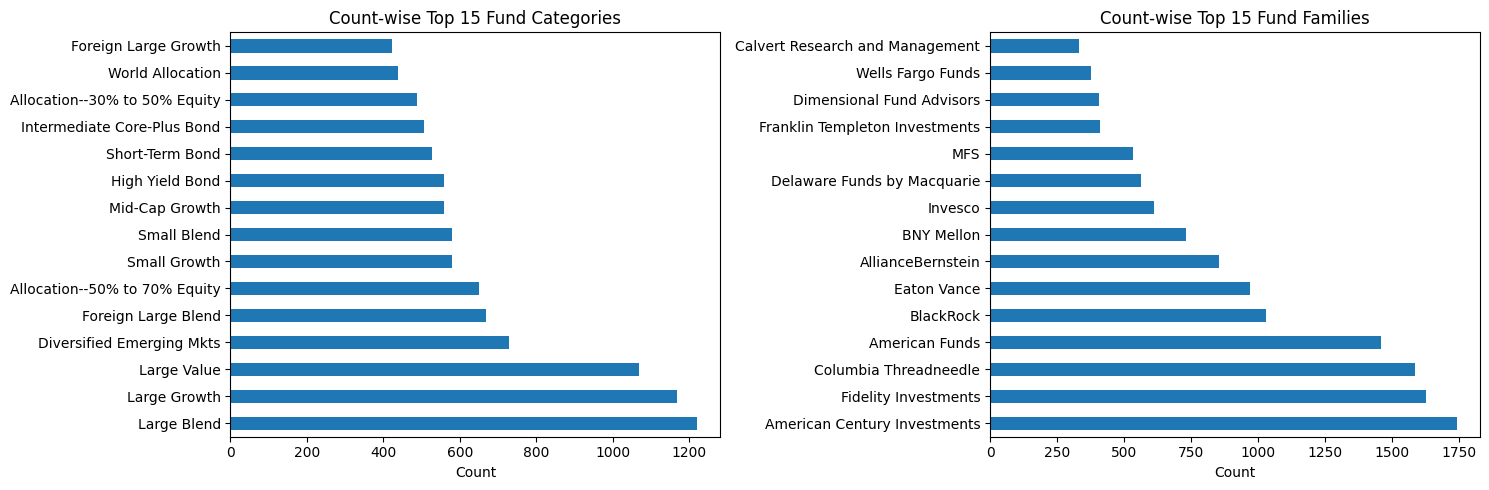

In [0]:
categorical_cols_2 = ['fund_category', 'fund_family']  # categorical columns with many unique values

category_counts = mf_df[categorical_cols_2[0]].value_counts().sort_values(ascending=False)  # number of occurrences of each unique value
family_counts = mf_df[categorical_cols_2[1]].value_counts().sort_values(ascending=False)

top_categories = category_counts[:15] # top 15 categories and families
top_families = family_counts[:15]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
top_categories.plot(kind='barh', ax=axs[0])
axs[0].set_title('Count-wise Top 15 Fund Categories')
axs[0].set_xlabel('Count')
top_families.plot(kind='barh', ax=axs[1])
axs[1].set_title('Count-wise Top 15 Fund Families')
axs[1].set_xlabel('Count')
plt.tight_layout()
plt.show()

## 4. Visualising funds' Financial and ESG performance over categories

In [0]:
for i in range (0, len(mf_df.columns)):
    print(mf_df.columns[i])

fund_symbol
quote_type
region
fund_short_name
fund_long_name
currency
initial_investment
subsequent_investment
fund_category
fund_family
exchange_code
exchange_name
exchange_timezone
management_name
management_bio
management_start_date
total_net_assets
year_to_date_return
day50_moving_average
day200_moving_average
week52_high_low_change
week52_high_low_change_perc
week52_high
week52_high_change
week52_high_change_perc
week52_low
week52_low_change
week52_low_change_perc
investment_strategy
fund_yield
morningstar_overall_rating
morningstar_risk_rating
inception_date
last_dividend
last_cap_gain
annual_holdings_turnover
investment_type
size_type
fund_annual_report_net_expense_ratio
category_annual_report_net_expense_ratio
fund_prospectus_net_expense_ratio
fund_prospectus_gross_expense_ratio
fund_max_12b1_fee
fund_max_front_end_sales_load
category_max_front_end_sales_load
fund_max_deferred_sales_load
category_max_deferred_sales_load
fund_year3_expense_projection
fund_year5_expense_projectio

In [0]:
# We study the following kind of performances for different fund categories

performance_cols = ['total_net_assets', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_price_earning_ratio']

esg_cols = ['environment_score', 'social_score', 'governance_score']

categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

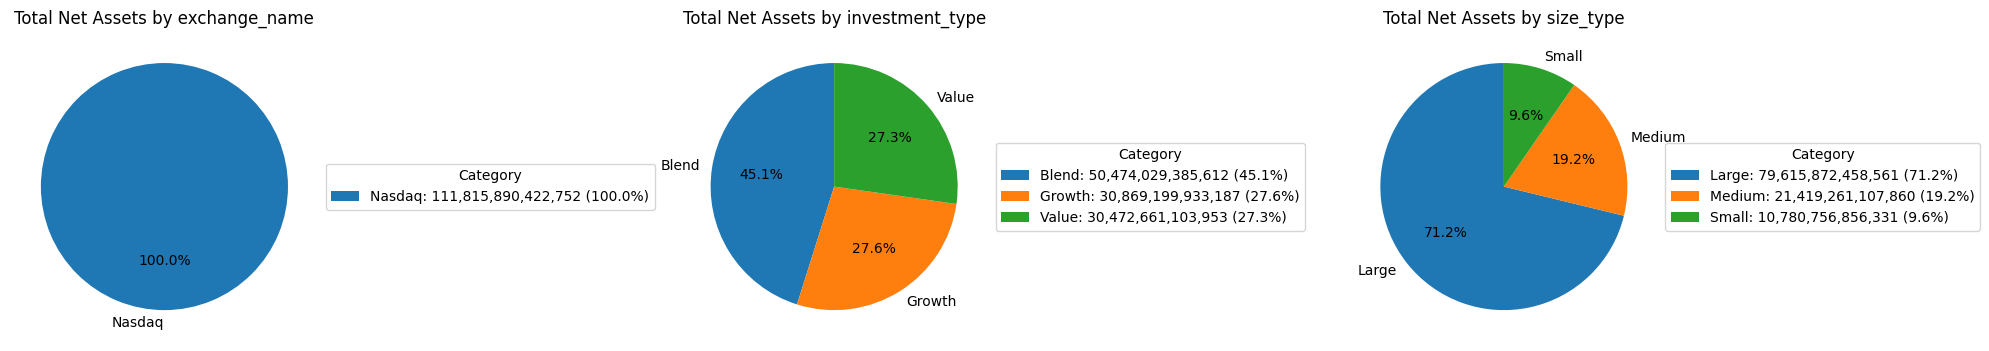

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# pie chart of total net assets
for i, col in enumerate(categorical_cols_1):
    data = mf_df.groupby(col)['total_net_assets'].sum().reset_index() # sum
    ax = axs[i]
    wedges, texts, autotexts = ax.pie(data['total_net_assets'], labels=data[col], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Total Net Assets by {col}')

    abs_vals = [f'{val:,.0f}' for val in data['total_net_assets']]
    legend_labels = [f'{cat}: {abs_val} ({val/sum(data["total_net_assets"])*100:.1f}%)' for cat, abs_val, val in zip(data[col], abs_vals, data['total_net_assets'])]
    ax.legend(wedges, legend_labels, title='Category', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

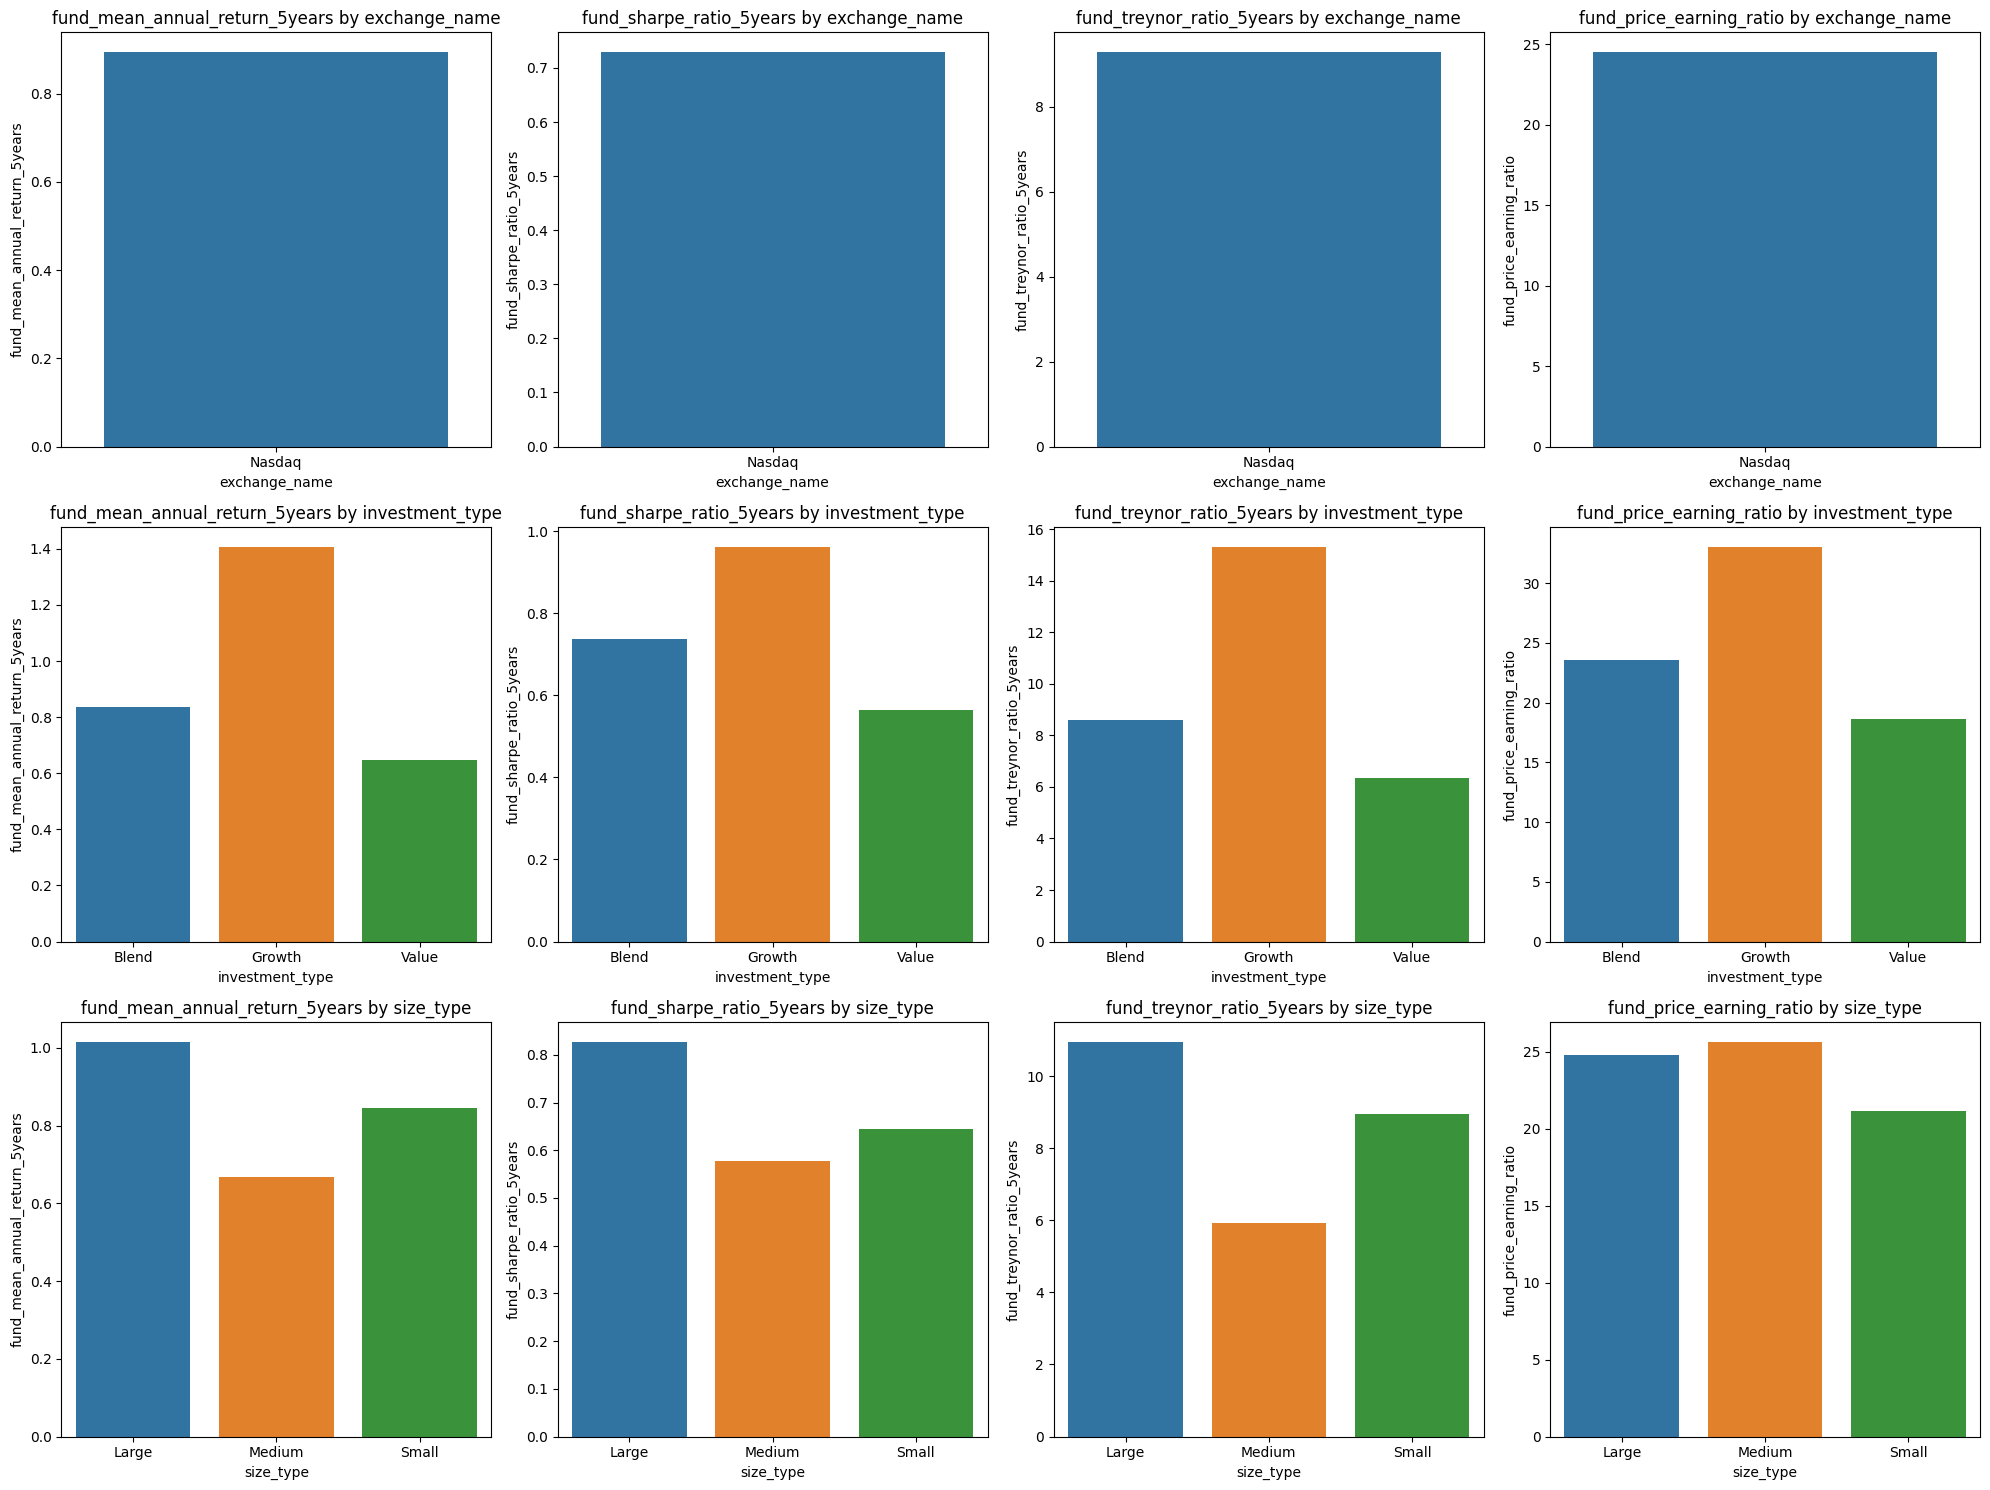

In [0]:
# bar plots now

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, col in enumerate(performance_cols[1:]):
    for j, cat_col in enumerate(categorical_cols_1):
        data = mf_df.groupby(cat_col)[col].mean().reset_index() # average

        ax = axs[j, i]
        sns.barplot(x=cat_col, y=col, data=data, ax=ax)
        ax.set_title(f'{col} by {cat_col}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(col)

plt.tight_layout()
plt.show()

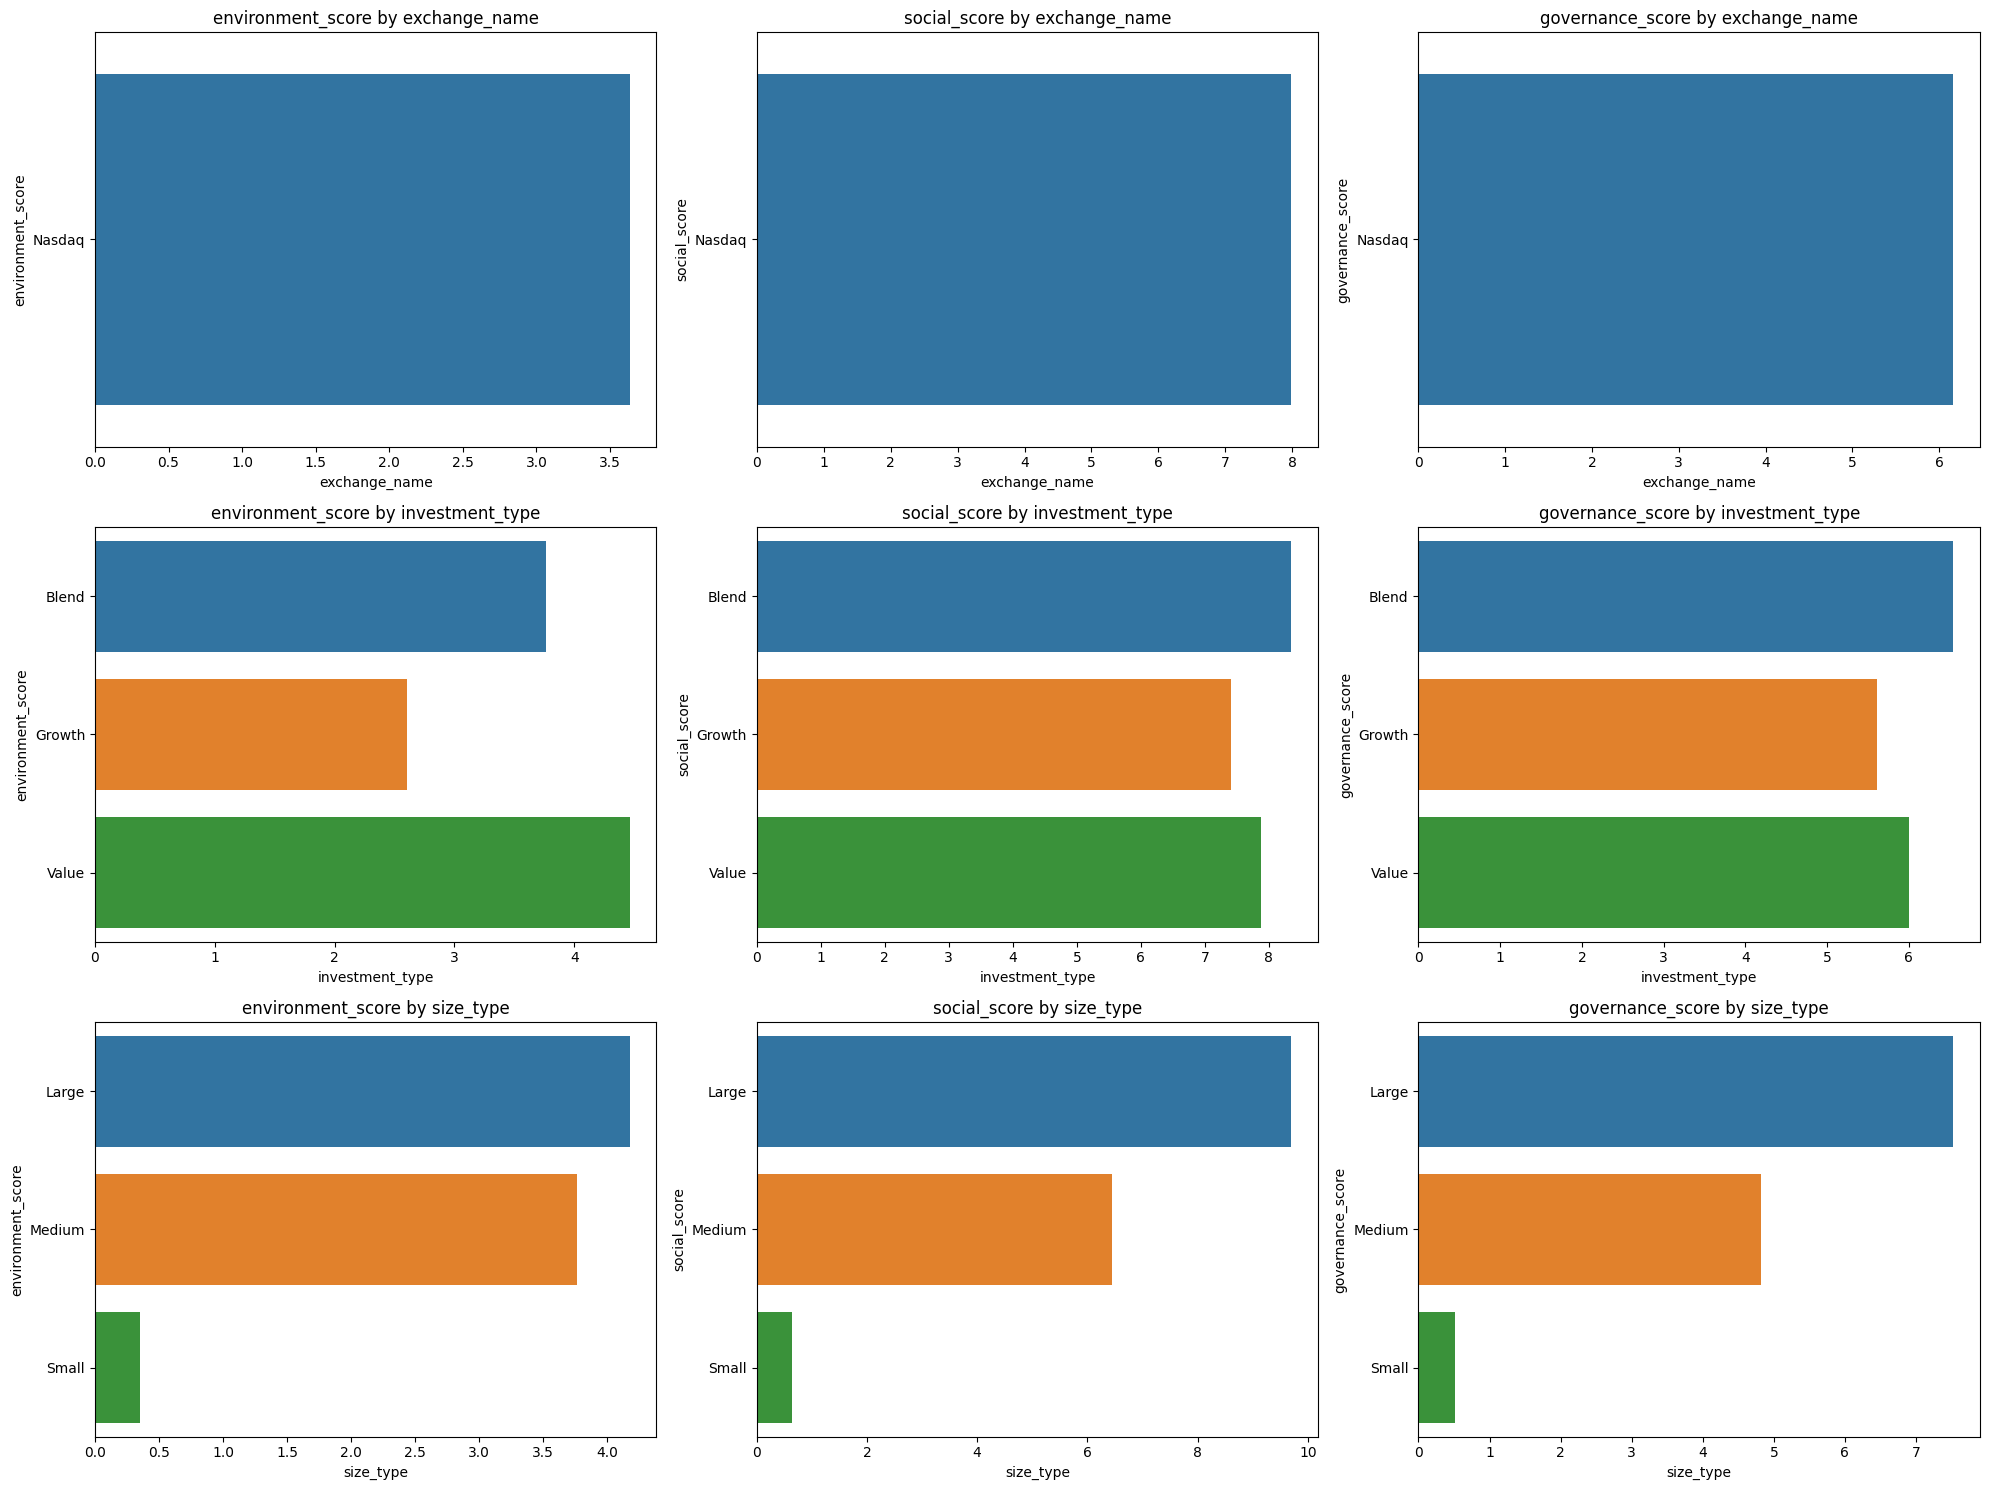

In [0]:
# ESG performance plots

fig, axs = plt.subplots(3, 3, figsize=(20, 15))

for i, col in enumerate(esg_cols):
    for j, cat_col in enumerate(categorical_cols_1):
        data = mf_df.groupby(cat_col)[col].mean().reset_index() # average

        ax = axs[j, i]
        sns.barplot(y=cat_col, x=col, data=data, ax=ax)
        ax.set_title(f'{col} by {cat_col}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(col)

plt.tight_layout()
plt.show()

## 5. Correlations (Overall + Conditioned on Categories)

### 5.1. Overall

<AxesSubplot:>

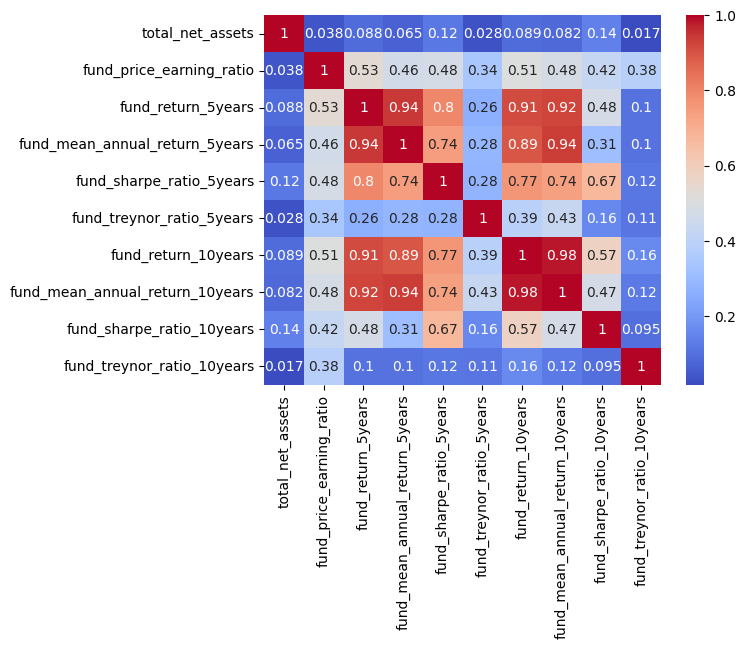

In [0]:
performance_cols = ['total_net_assets', 'fund_price_earning_ratio', 'fund_return_5years', 'fund_mean_annual_return_5years', 'fund_sharpe_ratio_5years', 'fund_treynor_ratio_5years', 'fund_return_10years', 'fund_mean_annual_return_10years', 'fund_sharpe_ratio_10years', 'fund_treynor_ratio_10years']
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

normalized_df = mf_df.copy() 
scaler = StandardScaler()
normalized_df[performance_cols] = scaler.fit_transform(mf_df[performance_cols]) # normalized data

corr_matrix = normalized_df[performance_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### 5.2. Conditioned on Categories

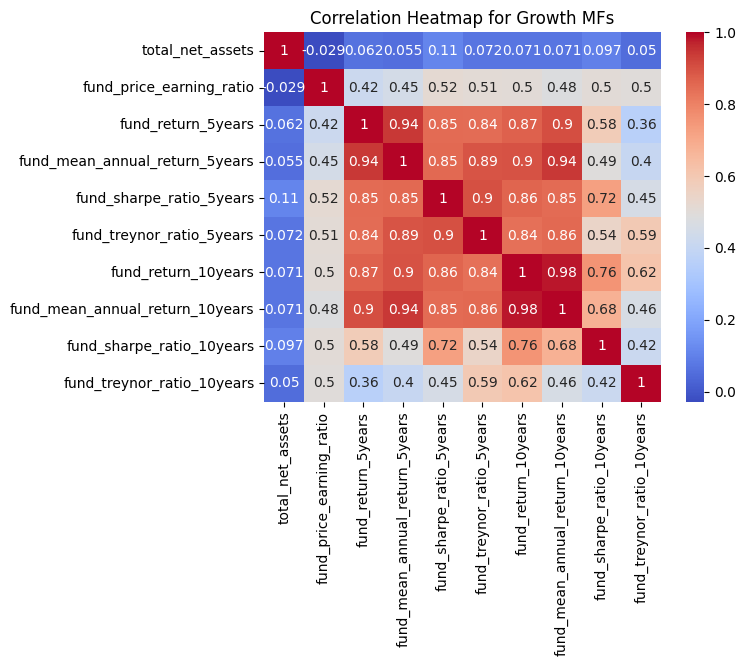

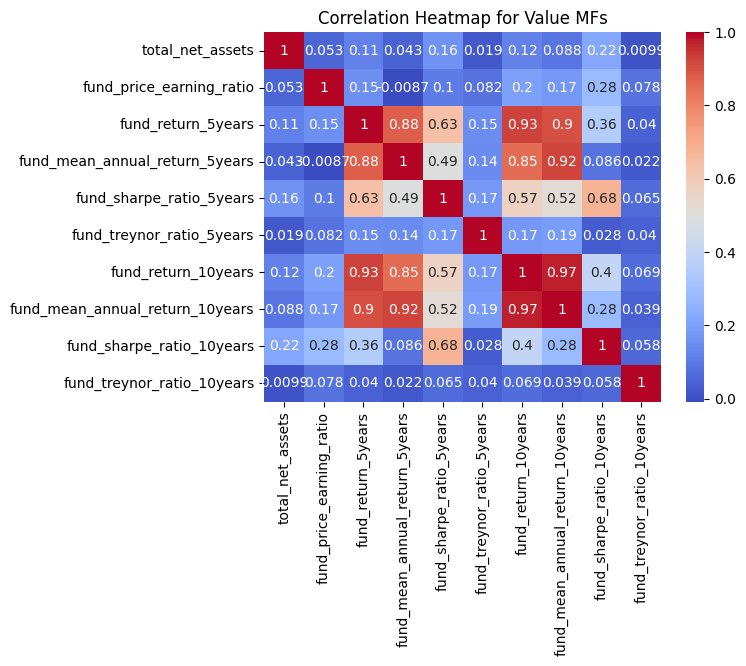

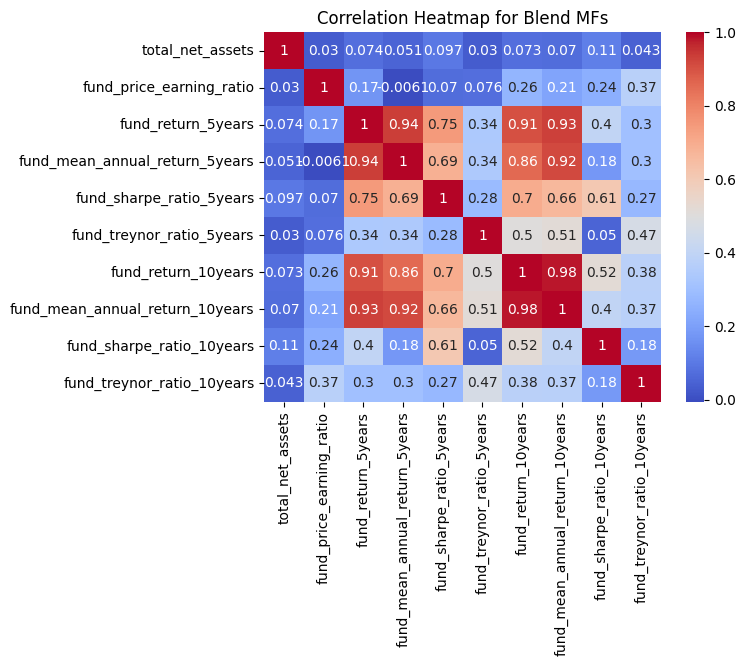

In [0]:
investment_types_ = ['Growth', 'Value', 'Blend'] 
for type_ in investment_types_:
    corr_matrix = normalized_df[normalized_df['investment_type']==type_][performance_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Heatmap for {type_} MFs')
    plt.show()

# size_types_ = ['Small', 'Medium', 'Large'] 
# for type_ in size_types_:
#     corr_matrix = normalized_df[normalized_df['size_type']==type_][performance_cols].corr()
#     sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#     plt.title(f'Correlation Heatmap for {type_} MFs')
#     plt.show()

## 6. MF prices over time

In [0]:
print(len(mf_prices_df))
mf_prices_df.head(5)

75657739


,fund_symbol,price_date,nav_per_share
0,AAAAX,2007-07-31,10.02
1,AAAAX,2007-08-01,9.98
2,AAAAX,2007-08-02,10.01
3,AAAAX,2007-08-03,9.90
4,AAAAX,2007-08-06,9.93


In [0]:
print(mf_prices_df.dtypes) # data types of every column

mf_prices_df['price_date'] = pd.to_datetime(mf_prices_df['price_date']) # convert 'price_date' column to datetime

print("*****")
print(mf_prices_df['price_date'].dtypes) # new data types of price_date

print("*****")

# range of time for which data is available
print(f"{mf_prices_df['price_date'].min()} to {mf_prices_df['price_date'].max()}")

fund_symbol       object
price_date        object
nav_per_share    float64
dtype: object
*****
datetime64[ns]
*****
1973-05-03 00:00:00 to 2021-11-30 00:00:00


price_date
1973       2241
1974       3542
1975       3542
1976       3542
1977       3655
1978       4032
1979       4105
1980      43465
1981      45380
1982      50130
1983      55453
1984      65704
1985      79277
1986     105178
1987     131287
1988     152970
1989     168216
1990     184626
1991     206586
1992     236830
1993     293627
1994     377973
1995     452900
1996     555574
1997     692204
1998     815375
1999     915842
2000    1019213
2001    1156972
2002    1330895
2003    1480214
2004    1637618
2005    1811680
2006    1975283
2007    2194973
2008    2450088
2009    2628095
2010    2832737
2011    3055229
2012    3285717
2013    3594670
2014    3885600
2015    4212216
2016    4574343
2017    4918614
2018    5232550
2019    5524634
2020    5774414
2021    5428728
dtype: int64


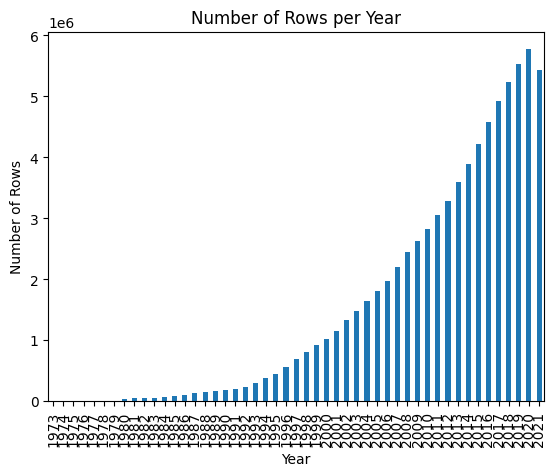

In [0]:
# visualising YoY entries in the price dataframe

year_counts = mf_prices_df.groupby(mf_prices_df['price_date'].dt.year).size()
print(year_counts)

year_counts.plot(kind='bar') # bar plot
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Year')
plt.show()

In [0]:
# trimming dataset before 2001 since I wish to analyse from this year
mf_prices_df = mf_prices_df[mf_prices_df['price_date'] > '2000-12-31']
print(len(mf_prices_df))
mf_prices_df.head(3)

68985270


,fund_symbol,price_date,nav_per_share
0,AAAAX,2007-07-31,10.02
1,AAAAX,2007-08-01,9.98
2,AAAAX,2007-08-02,10.01


In [0]:
# adding categorical_cols in the mf_prices dataframe 
categorical_cols= ['exchange_name', 'investment_type', 'size_type', 'fund_category', 'fund_family'] # categorical columns handpicked from object columns
mf_prices_df = mf_prices_df.merge(mf_df[categorical_cols + ['fund_symbol']], on='fund_symbol', how='left')
mf_prices_df.head(5)

,fund_symbol,price_date,nav_per_share,exchange_name,investment_type,size_type,fund_category,fund_family
0,AAAAX,2007-07-31,10.02,Nasdaq,Value,Large,World Allocation,DWS
1,AAAAX,2007-08-01,9.98,Nasdaq,Value,Large,World Allocation,DWS
2,AAAAX,2007-08-02,10.01,Nasdaq,Value,Large,World Allocation,DWS
3,AAAAX,2007-08-03,9.90,Nasdaq,Value,Large,World Allocation,DWS
4,AAAAX,2007-08-06,9.93,Nasdaq,Value,Large,World Allocation,DWS


###  6.1. year on year split of MF funds on categorical columns i.e. Count of MFs v/s categorical columns

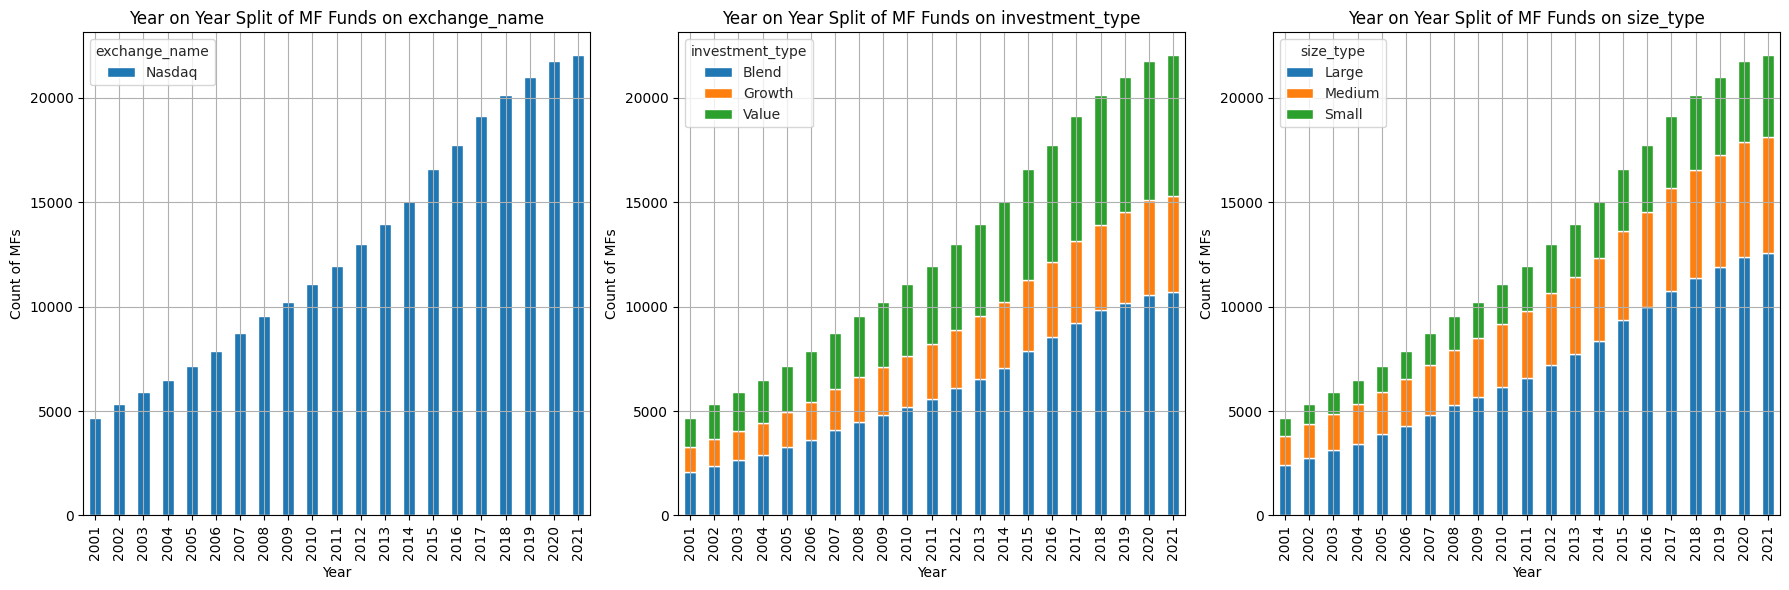

In [0]:
mf_prices_df.set_index('price_date', inplace=True)

categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(categorical_cols_1):
    mf_category_count_df = mf_prices_df.groupby([mf_prices_df.index.year, col])['fund_symbol'].nunique().reset_index(name='count')
    mf_category_count_pivot = mf_category_count_df.pivot(index='price_date', columns=col, values='count').fillna(0)
    
    sns.set_style('whitegrid')
    mf_category_count_pivot.plot(kind='bar', stacked=True, ax=axs[i]) # stacked bar_plot
    #mf_category_count_pivot.plot(kind='line', ax=axs[i])
    axs[i].set_title(f'Year on Year Split of MF Funds on {col}')
    axs[i].set_xlabel('Year')
    axs[i].set_xticklabels(mf_category_count_pivot.index, rotation=90)
    axs[i].set_ylabel('Count of MFs')

plt.tight_layout()
plt.show()

###  6.2. year on year split of 'average NAV per share of MF funds' on categorical columns i.e. Average NAV per share of MFs v/s categorical columns

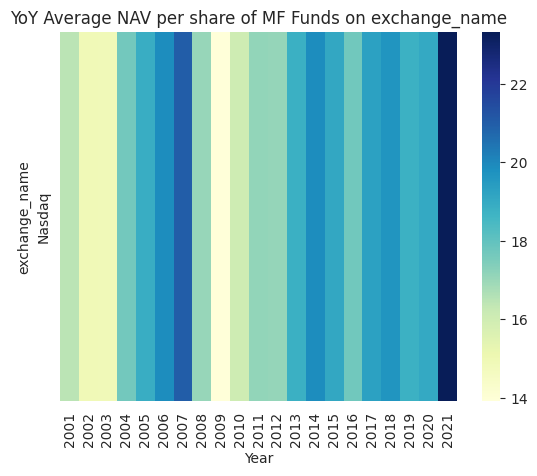

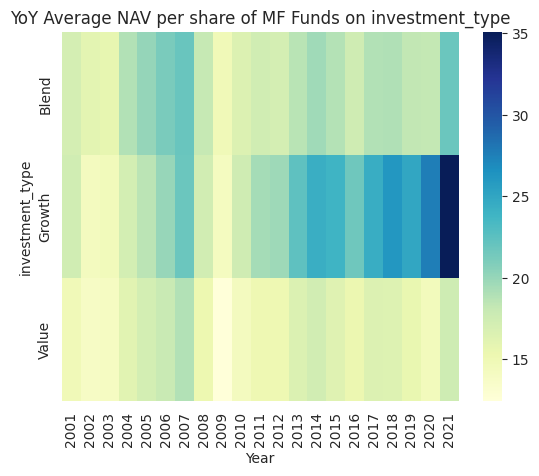

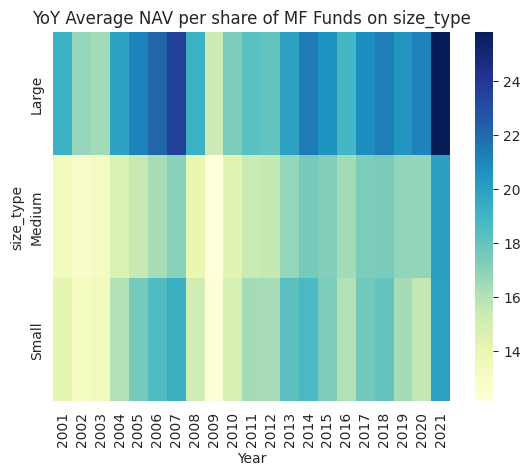

In [0]:
categorical_cols_1 = ['exchange_name', 'investment_type', 'size_type']

for col in categorical_cols_1:
    mf_nav_df = mf_prices_df.groupby([mf_prices_df.index.year, col])['nav_per_share'].mean().reset_index(name='average_nav_per_share')

    mf_nav_pivot = mf_nav_df.pivot(index=col, columns='price_date', values='average_nav_per_share')

    sns.set_style('whitegrid')
    sns.heatmap(mf_nav_pivot, cmap='YlGnBu')
    plt.title(f'YoY Average NAV per share of MF Funds on {col}')
    plt.xlabel('Year')
    plt.xticks(rotation=90)
    plt.ylabel(col)
    plt.show()

    # Net Asset Value is the net value of an investment fund's assets less its liabilities, divided by the number of shares outstanding. NAV is commonly used as a per-share value calculated for a mutual fund or ETF.

*****